In [1]:
%load_ext ipycache

/Users/armin/miniconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/armin/miniconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# utility libraries
import numpy as np
from utils import *
from sklearn.linear_model import LogisticRegression
import pandas as pd
import pdb
import imp 
import time 
from sklearn.linear_model import LogisticRegression
from time import time
#parallelizing 
from joblib import Parallel, delayed
from pathos import multiprocessing 
from pathos.multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')
import sys


# Plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches
colors = np.array(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#650021"])
figSaveFile = "fig/"
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


In [3]:
# Constants 

red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
orange = (0.8, 0.7254901960784313, 0.4549019607843137)
totDOs = 5

# Determine step-size

In [4]:
def batch_stepsize_test(totCount, dim, totDOs,f, bs, hs,x, eta, dtype='m'): # f is for fraction of categorical covariates 
    np.random.seed(982451653*x%1235641343)
    beta = np.random.normal(0,1,dim + 1)
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
    center = DataCenter(dim)
    for i, n in enumerate(num):
        DataRepo(n, dtype, dim, beta, center, f)
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_regression(center)
    betas = np.zeros((5, betaL.shape[0]))
    
    betas[0,:] = center.SQN(50,10,eta,bs,hs, max_iters=1000).ravel() #SQN beta
    betas[1,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=eta)[0]      # simple sgd 
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=1, step=eta)[0]    #adagrad 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=2, step=eta)[0]     #rms prop 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=3, step=eta)[0]     #adadelta 
    
    costs = np.zeros((6,3))
    for i in xrange(5):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[5,:] = cost, roc, zeroone
    return costs

In [5]:
%%cache logstepsize.pkl stepsizemixedData 
all_etas = [[0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0],
        [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0],
        [0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]]
s = "steps"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizemixedData = []
Ns = [100,1000, 10000]
bs = [0.1] * len(Ns)
hs = [0.3] * len(Ns)
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    etas = all_etas[i]
    for eta in etas:
        nnum= Ns[i]
        f = lambda x: batch_stepsize_test(x[1],x[2],5,0.5, x[3], x[4],x[0],x[5])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizemixedData.append(results)
print time()-t0

[Skipped the cell's code and loaded variables stepsizemixedData from file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/logstepsize.pkl'.]
6640.23932981


In [6]:
print np.mean(np.array(stepsizemixedData)[8:16,:,:,0], axis = 1)

[[ 0.31863574  0.58303721  0.47005499  0.22753048  0.22816116  0.22476603]
 [ 0.2249053   0.41613062  0.29293712  0.2264303   0.22635976  0.22476603]
 [ 0.22510643  0.35122722  0.25217883  0.22827156  0.22801226  0.22476603]
 [ 0.2265382   0.26081258  0.22623464  0.24957348  0.24617139  0.22476603]
 [ 0.22873381  0.24277777  0.22591247  0.28941583  0.28024407  0.22476603]
 [        nan  0.22688009  0.23042682  0.86085385  0.76683446  0.22476603]
 [        nan  0.22543528  0.23664192  1.62739265  1.46950521  0.22476603]
 [        nan  0.22514887  0.33380018  3.82297481  3.63656854  0.22476603]]


In [7]:
np.mean(np.array(stepsizemixedData)[:9,:,:,0], axis = 1)

array([[ 0.30813515,  0.57489399,  0.48314412,  0.21936033,  0.22056175,
         0.20044146],
       [ 0.20485518,  0.40248662,  0.29329687,  0.21111738,  0.20976139,
         0.20044146],
       [        nan,  0.33698464,  0.24684116,  0.21713327,  0.21394898,
         0.20044146],
       [        nan,  0.24566293,  0.21010627,  0.28412777,  0.26747207,
         0.20044146],
       [        nan,  0.22669953,  0.20884419,  0.40133201,  0.36777932,
         0.20044146],
       [        nan,  0.20804075,  0.22299286,  1.65162857,  1.44081952,
         0.20044146],
       [        nan,  0.20629913,  0.26183121,  3.02423183,  2.95706397,
         0.20044146],
       [        nan,  0.23035407,  3.08276002,  5.19062566,  5.5105741 ,
         0.20044146],
       [ 0.31863574,  0.58303721,  0.47005499,  0.22753048,  0.22816116,
         0.22476603]])

In [8]:
[all_etas[0][i] for i in np.nanargmin(np.mean(np.array(stepsizemixedData)[:8,:,:,0], axis = 1), axis=0)]

NameError: name 'all_etas' is not defined

In [88]:
[all_etas[1][i] for i in np.nanargmin(np.mean(np.array(stepsizemixedData)[8:16,:,:,0], axis = 1), axis=0)]

[0.05, 50.0, 1.0, 0.05, 0.05, 0.01]

In [89]:
[all_etas[2][i] for i in np.nanargmin(np.mean(np.array(stepsizemixedData)[16:,:,:,0], axis = 1), axis=0)]

[0.05, 50.0, 1.0, 0.05, 0.05, 0.05]

In [91]:
np.mean(np.array(stepsizemixedData)[:8,:,1,0], axis=1)

array([ 0.57489399,  0.40248662,  0.33698464,  0.24566293,  0.22669953,
        0.20804075,  0.20629913,  0.23035407])

In [92]:
print np.mean(np.array(stepsizemixedData)[:,:,:,0], axis = 1) 

[[ 0.30813515  0.57489399  0.48314412  0.21936033  0.22056175  0.20044146]
 [ 0.20485518  0.40248662  0.29329687  0.21111738  0.20976139  0.20044146]
 [        nan  0.33698464  0.24684116  0.21713327  0.21394898  0.20044146]
 [        nan  0.24566293  0.21010627  0.28412777  0.26747207  0.20044146]
 [        nan  0.22669953  0.20884419  0.40133201  0.36777932  0.20044146]
 [        nan  0.20804075  0.22299286  1.65162857  1.44081952  0.20044146]
 [        nan  0.20629913  0.26183121  3.02423183  2.95706397  0.20044146]
 [        nan  0.23035407  3.08276002  5.19062566  5.5105741   0.20044146]
 [ 0.31863574  0.58303721  0.47005499  0.22753048  0.22816116  0.22476603]
 [ 0.2249053   0.41613062  0.29293712  0.2264303   0.22635976  0.22476603]
 [ 0.22510643  0.35122722  0.25217883  0.22827156  0.22801226  0.22476603]
 [ 0.2265382   0.26081258  0.22623464  0.24957348  0.24617139  0.22476603]
 [ 0.22873381  0.24277777  0.22591247  0.28941583  0.28024407  0.22476603]
 [        nan  0.22688009

In [93]:
print np.min(np.mean(np.array(stepsizemixedData)[:9,:,1,0], axis = 1))
print np.min(np.mean(np.array(stepsizemixedData)[9:,:,1,0], axis = 1))

0.206299134008
0.224238188688


# simulations

## Number of covariates 

In [192]:
totDOs = 5
def all_algs(totCount, dim, totDOs,f, bs, hs,x, dtype='m'): # f is for fraction of categorical covariates 
    np.random.seed(982451653*x%1235641343)
    beta = np.random.normal(0,1,dim + 1)
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
    center = DataCenter(dim)
    for i,n in enumerate(num):
        DataRepo(n, dtype, dim, beta, center, f)
    center.count_data()
    center.scale()
    betaL, cost, roc, zeroone = all_regression(center)
    betas = np.zeros((7,betaL.shape[0]))
    if totCount < 500 and totCount > 50:
        etas = [0.05, 10.0, 1.0, 0.05, 0.05]
    elif totCount < 5000 and totCount > 500:
        etas = [0.05, 50.0, 1.0, 0.05, 0.05]
    elif totCount > 5000 and totCount < 5e4:
        etas = [0.05, 50.0, 1.0, 0.05, 0.05]
    
    betas[0,:] = center.avgLogistic()     # averaging 
    betas[1,:] = center.SQN(50,10,etas[0],bs,hs, max_iters=1000).ravel()   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=etas[1])[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=1, step=etas[2])[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=2, step=etas[3])[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=3, step=etas[4])[0]     #adadelta 
    betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

In [182]:
#%%cache PN0Results.pkl datapn0
s = "time0"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 10
datapn0 = []
Ns = [100,1000, 10000]
bs = [0.1, .1,.1]
hs = [0.3, .3,.3]
Ps = [1,2,5,10]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: all_algs(x[1],x[2],5,0, x[3], x[4],x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        datapn0.append(results)
print time()-t0


400.595676899


In [162]:
%%cache PN1Results.pkl datapn1
s = "PNexp1"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
datapn1 = []
Ns = [100,1000, 10000]
bs = [0.1, .1,.1]
hs = [0.3, .3,.3]
Ps = [1,2,5,10]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: all_algs(x[1], x[2],5, 1.0, x[3], x[4], x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        datapn1.append(results)
print time()-t0

[Skipped the cell's code and loaded variables datapn1 from file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/PN1Results.pkl'.]
4359.94717097


In [30]:
%%cache PN05Results.pkl datapn05
s = "PNexp05"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
datapn05 = []
Ns = [100,1000, 10000]
bs = [0.1, .1,.1]
hs = [0.3, .3,.3]
Ps = [1,2,5,10]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: all_algs(x[1], x[2],5, 0.5, x[3], x[4], x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        datapn05.append(results)
print time()-t0

[Saved variables datapn05 to file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/PN05Results.pkl'.]
7597.29314303


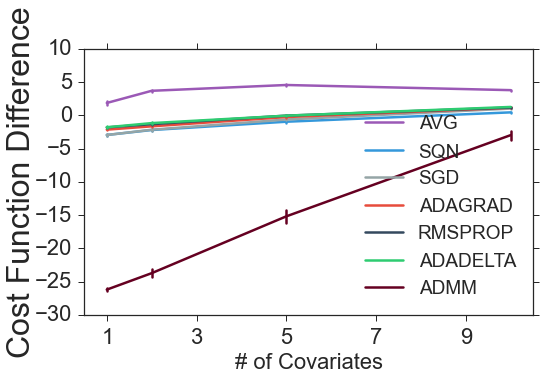

In [26]:
P = [2,3,6,11]
P = P + P + P
N = [100] * 4 + [1000] * 4 + [10000] * 4
df = df_from_pn(P,N, datapn0)
name, n, loss = 'allpnResults0', 100, 0

ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],'Cost Function Difference',[-30,10])
#ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

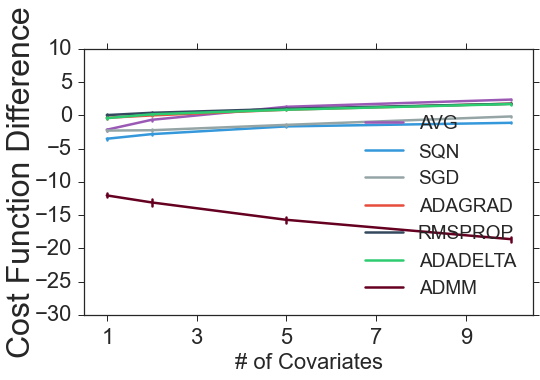

In [27]:
P = [2,3,6,11]
P = P + P + P
N = [100] * 4 + [1000] * 4 + [10000] * 4
df = df_from_pn(P,N, datapn0)
name, n, loss = 'allpnResults0', 10000, 0

ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],'Cost Function Difference',[-30,10])

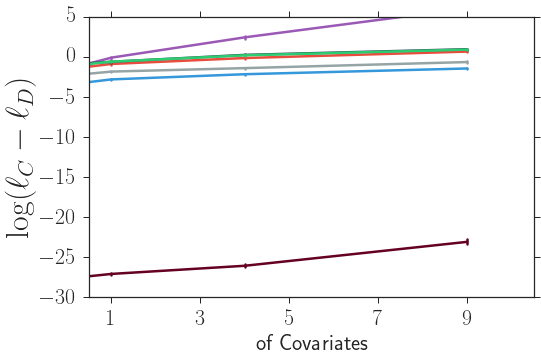

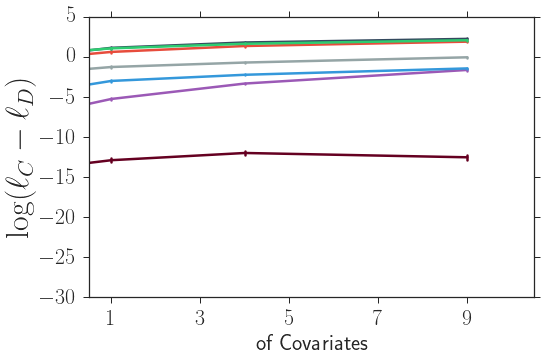

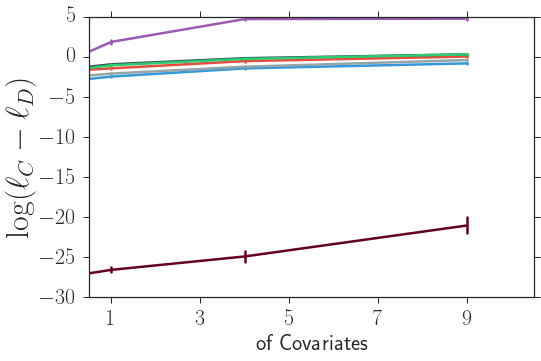

In [54]:
#Plotting 
plt.rc('text', usetex=True)

P = [1,2,5,10]
P = P + P + P
N = [100] * 4 + [1000] * 4 + [10000] * 4
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, loss = 'datapn0', 1000, 0
df = df_from_pn(P,N, datapn0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.min(df1.value[np.logical_not(np.isneginf(df1.value))])
#df1['value'].fillna((df1['value'].mean()), inplace=True)

ax = plot_pn(df1,text,window)
#ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'datapn0', 10000, 0
df = df_from_pn(P,N, datapn1)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
#df1.value[np.isneginf(df1.value)] = np.nan 
#df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
#ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'datapn0', 100, 0
df = df_from_pn(P,N, datapn1)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.min(df1.value[np.logical_not(np.isneginf(df1.value))])
#df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
#ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

#  this one needs special attention, one of the values ended up being nan, so we will delete that and relvant counts

## Number of DO's

## Convergence Speed

In [5]:
totDOs = 5
def convSpeed(totCount, dim, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(982451653*x%1235641343)
    beta = np.random.normal(0,1,dim + 1)
    #beta[0] = 0
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/float(totDOs * 2))):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
    center = DataCenter(dim)
    for i,n in enumerate(num):
        DataRepo(n, 'm', dim, beta, center, f)
        
    if totCount < 500 and totCount > 50:
        etas = [0.05, 10.0, 1.0, 0.05, 0.05]
    elif totCount < 5000 and totCount > 500:
        etas = [0.05, 50.0, 1.0, 0.05, 0.05]
    elif totCount > 5000 and totCount < 5e4:
        etas = [0.05, 50.0, 1.0, 0.05, 0.05]
        
    iters = 2000
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone, AF = all_regression(center)
    betas = np.zeros((6,betaL.shape[0],iters/10+1))
    
    Avg_value = center.avgLogistic()     # averaging 
    betas[0,:,:] = center.SQN(50,10, etas[0],bs,hs, max_iters=iters,verbose=True)   #SQN beta
    betas[1,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, step=etas[1],verbose=True)     # simple sgd 
    betas[2,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, stepAlg=1, step=etas[2],verbose=True)   #adagrad 
    betas[3,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, stepAlg=2, step=etas[3],verbose=True)    #rms prop 
    betas[4,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, stepAlg=3, step=etas[4],verbose=True)     #adadelta 
    betas[5,:,:] = center.ADMM(1.0, max_iters=iters,verbose=True)    # admm 
    costs = np.zeros((7,3,iters/10+1))
    for i in xrange(6):
        for j in xrange(iters/10+1):
            costs[i,:,j] = center.evaluate(betas[i,:,j])
    for j in xrange(iters/10+1):
        costs[6,:,j] = cost, roc, zeroone
    avg_cost = center.evaluate(Avg_value)
    return costs, avg_cost, AF

In [6]:
%%cache convSpeed0.pkl alltimeResults0 
s = "time0"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 200
alltimeResults0 = []
Ps = [1,2,5,10]
Ns = [100, 1000, 10000]
bs = [0.1, .1, .1]
hs = [0.3, .3, .3]
p = Pool(4)
inputs=range(1,reps+1)

t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: convSpeed(x[1],x[2],5,0.0, x[3], x[4],x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
    alltimeResults0.append(temp)
print time()-t0

[Skipped the cell's code and loaded variables alltimeResults0 from file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/convSpeed0.pkl'.]
1 

2 

5 

10 

1 

2 

5 

10 

1 

2 

5 

10 

25874.8590739


In [7]:
%%cache convSpeed1.pkl alltimeResults1 
s = "time1"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 200
alltimeResults1 = []
Ps = [1,2,5,10]
Ns = [100, 1000, 10000]
bs = [0.1, .1, .1]
hs = [0.3, .3, .3]
p = Pool(4)
inputs=range(1,reps+1)

t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: convSpeed(x[1],x[2],5,1.0, x[3], x[4],x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
    alltimeResults1.append(temp)
print time()-t0

[Skipped the cell's code and loaded variables alltimeResults1 from file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/convSpeed1.pkl'.]
18788.3797688


In [9]:
%%cache convSpeed1_10.pkl alltimeResults1
s = "time1"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 200
alltimeResults1_10 = []
Ps = [1,2,5,10]
Ns = [1000, 10000]
bs = [.1, .1]
hs = [.3, .3]
p = Pool(4)
inputs=range(1,reps+1)

t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: convSpeed(x[1],x[2],10,1.0, x[3], x[4],x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
    alltimeResults1_10.append(temp)
print time()-t0

IndexError: list index out of range

[Saved variables alltimeResults1 to file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/convSpeed1_10.pkl'.]


In [206]:
x = keywords[0]
convSpeed(x[1],x[2],10,1.0, x[3], x[4],x[0])

ZeroDivisionError: float division by zero

In [8]:
%%cache convSpeed05.pkl alltimeResults05
s = "time05"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 200
alltimeResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000]
bs = [0.1, .1, .1]
hs = [0.3, .3, .3]
p = Pool(4)
inputs=range(1,reps+1)

t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        f = lambda x: convSpeed(x[1],x[2],5,0.5, x[3], x[4],x[0])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
    alltimeResults05.append(temp)
print time()-t0

[Skipped the cell's code and loaded variables alltimeResults05 from file '/Users/armin/Documents/Bust_lab/online-regression/Decentralized_reg/convSpeed05.pkl'.]
33859.7181852


In [5]:
def df_convergance(P,N, sim, DO=5):
    df = pd.DataFrame()
    sim = np.array(sim)
    exps = sim.shape[2]
    tp = sim.shape[5]
    reshaped = np.empty((exps * tp,9))
    for k in range(1):
        for i,n in enumerate(N):
            for j,p in enumerate(P):
                for l in range(exps):
                    reshaped[l*tp:((l+1)*tp),:7] = sim[i,j,l,:,k,:].T
                    reshaped[l*tp:((l+1)*tp),7] = [l]*tp
                    reshaped[l*tp:((l+1)*tp),8] = range(0,tp*10,10)
                cov = np.array([p]*exps*tp,ndmin=2).T
                size = np.array([n]*exps*tp,ndmin=2).T
                r = np.repeat(range(tp),exps).reshape(tp*exps,1)
                appended = np.hstack((reshaped,cov,size))
                df = df.append(pd.DataFrame(data=appended, columns= ['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM',
                                                                 'logistic', 'range', 'tps','covariates','n']))
    df1 = df
    df1 = (df1[['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0))
    #df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]).div(df1['logistic']+ 10**-10, axis=0)
    df.loc[:, ['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]
    df = pd.melt(df, id_vars=["covariates","n",'range','tps'])
    logs = np.log(df.value)
    df.value = logs
    df.value[np.isnan(logs) | ~np.isfinite(logs)] = min(logs[~np.isnan(logs) & np.isfinite(logs)])
    return df

def plot_time(df,ylab,ylim):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    sns.tsplot(time="tps", value="value", condition="variable",
           unit="range",data=df, err_style="ci_band",ax=ax
           ,interpolate=True,legend=True)
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('Iterations', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=-2)
    #ax.yaxis.set_label_coords(-.09, -.2)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(0, 2000)  # outliers only
    plt.legend(loc='best')
    ax.set_xticks(np.arange(0,2000,200))
    ax.tick_params(labelsize=22)
    sns.set_style("ticks")
    plt.tight_layout()
    return f

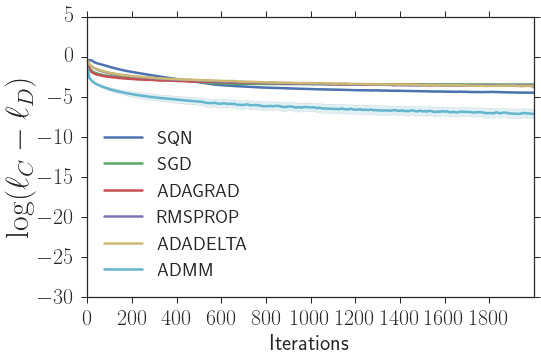

In [92]:
plt.rc('text', usetex=True)

Ps = [1,2,5,10]
#N = [1000] * 4 + [10000] * 4 + [100] * 4
Ns = [100, 1000, 10000]
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, p= 'alltimeResults0', 100, 10
df = df_convergance(Ps,Ns, alltimeResults0)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic')],text,window)

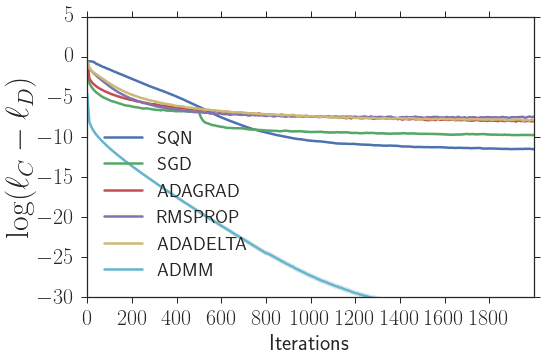

In [78]:
plt.rc('text', usetex=True)

Ps = [1,2,5,10]
#N = [1000] * 4 + [10000] * 4 + [100] * 4
Ns = [100, 1000, 10000]
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, p= 'alltimeResults0', 10000, 10
df = df_convergance(Ps,Ns, alltimeResults0)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic')],text,window)

# Figures used in the paper:

In [10]:
sim = np.array(alltimeResults0)
sim.shape

(3, 4, 200, 3)

In [323]:
sim = np.array(sim)
reps = sim.shape[2]
ts = sim[0,0,0,0].shape[2]
n_algs = sim[0,0,0,0].shape[0]
Ps = [1,2,5,10]
Ns = [100, 1000, 10000]

#make index

# high_indx = zip(np.repeat(Ns, len(Ps)), Ps * len(Ns))
# high_indx = np.array([list(item) for item in high_indx] * reps)
# r = np.repeat(range(reps), len(high_indx)/reps)
# r.shape = (r.shape[0],1)
# indx = np.hstack((high_indx, r))
# indx = [tuple(item) for item in indx]
# length_index = len(indx)
# indx = pd.MultiIndex.from_tuples(indx, names=["sample_size", 'num_cov', 'rep'])

data = np.zeros((length_index, ts, n_algs + 2)) #we'll just store the cost function

l = 0
for i, n in enumerate(Ns):
    for j, p in enumerate(Ps):
        for k in range(reps):
            data[l,:, :n_algs] = sim[i,j,k,0][:,0,:].T
            data[l,:,-2] = sim[i,j,k,1][0]
            data[l,:,-1] = min(sim[i,j,k,2] / float(n), 1-sim[i,j,k,2] / float(n))
            l += 1
# indx_arrays = [np.repeat(Ns, len(Ps) * reps), 
#                np.array(list(np.repeat(Ps, reps)) * len(Ns)),
#               np.array(range(reps) * (len(Ns) * len(Ps)))]
#df = pd.Panel(data, items=['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM', 'LOGISTIC','AVG'])
#df = df.to_frame()
#data = df.as_matrix()
indx = pd.MultiIndex.from_product([Ns, Ps, range(reps), range(ts)], names=['Size', 
                                                                          'Covariates', 'experiment', 'tp'])
data = np.array([subitem for item in data for subitem in item])
df = pd.DataFrame(data, indx, columns=['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM', 
                                       'LOGISTIC','AVG', 'AF'] )
df = (df[['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'AVG', 'ADMM']].sub(df['LOGISTIC'], axis=0))
df.reset_index(inplace=True)
df = pd.melt(df, id_vars=["Size","Covariates",'experiment', 'tp'])

        

In [166]:
def df_from_time(Ps,Ns, sim, DO=5):
    sim = np.array(sim)
    reps = sim.shape[2]
    ts = sim[0,0,0,0].shape[2]
    n_algs = sim[0,0,0,0].shape[0]


    #make index turns out this is pretty roundabout but Ill keep it for now
    data = np.zeros((len(Ns) * len(Ps) * reps, ts, n_algs + 2)) #we'll just store the cost function

    l = 0
    for i, n in enumerate(Ns):
        for j, p in enumerate(Ps):
            for k in range(reps):
                data[l,:, :n_algs] = sim[i,j,k,0][:,0,:].T
                data[l,:,-2] = sim[i,j,k,1][0]
                data[l,:,-1] = min(sim[i,j,k,2] / float(n), 1-sim[i,j,k,2] / float(n))
                l += 1
    indx = pd.MultiIndex.from_product([Ns, Ps, range(reps), range(ts)], names=['Size', 
                                                                          'Covariates', 'Experiment', 'tp'])
    data = np.array([subitem for item in data for subitem in item])
    df = pd.DataFrame(data, indx, columns=['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM', 
                                       'LOGISTIC','AVG', 'AF'] )
    df1 = (df[['SGD', 'ADAGRAD', 'SQN', 'ADADELTA', 'RMSPROP', 'AVG', 'ADMM']].sub(df['LOGISTIC'], axis=0))
    df1['AF'] = df.AF
    df1.reset_index(inplace=True)
    df = df1
    del df1

    df = pd.melt(df, id_vars=["Size","Covariates",'Experiment', 'tp', 'AF'])
    df.tp = df.tp * 10
    logs = np.log(df.value)
    df.value = logs
    df.value[np.isnan(logs) | ~np.isfinite(logs)] = min(logs[~np.isnan(logs) & np.isfinite(logs)])
    return df

def plot_time(df,ylab,ylim, xlab='\# of Covariates', xlim=(0, 2010)):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(xlim)  # outliers only
    sns.tsplot(time="tp", value="value", condition="variable",
           unit="Experiment",data=df, err_style="ci_band", ax=ax
           ,interpolate=True, legend=False, ci=99, color="hls")
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('Iterations', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=-2)
    #ax.yaxis.set_label_coords(-.09, -.2)
    plt.legend(loc='best')
    ax.set_xticks(np.arange(xlim[0], xlim[1],200))
    ax.tick_params(labelsize=22)
    ax.lines[-2].set_linestyle('--')
    markers = ['D', 'o', 'p', 's', '^']
#     ax.lines[0].markers_on = range(6,ylim[1],10)
#     ax.lines[1].markers_on = range(0,ylim[1],10)
#     ax.lines[2].markers_on = range(3,ylim[1],10)
    for i in range(5):
        ax.lines[i].set_marker(markers[i])
        ax.lines[i].set_markevery(slice((3*i + i)%5, xlim[1], 10))
        ax.lines[i].set_linestyle('')
#     ax.lines[i].set_markevery = range(3*i, ylim[1], 10) for i in range(5)
    
#     
#     ax.lines[-1].set_linestyle('-')
    sns.set_style("ticks")
    plt.tight_layout()
    #sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    return plt

In [200]:
df[(df.Size==n) & (df.Covariates==10) & (df.tp<=1000)  & (df.AF<.2)]

,Size,Covariates,Experiment,tp,AF,variable,value
284214,1000,10,14,0,0.190,SGD,-0.617287
284215,1000,10,14,10,0.190,SGD,-3.288570
284216,1000,10,14,20,0.190,SGD,-4.385701
284217,1000,10,14,30,0.190,SGD,-4.645955
284218,1000,10,14,40,0.190,SGD,-4.388227
284219,1000,10,14,50,0.190,SGD,-3.786231
284220,1000,10,14,60,0.190,SGD,-4.070201
284221,1000,10,14,70,0.190,SGD,-4.015902
284222,1000,10,14,80,0.190,SGD,-4.621752
284223,1000,10,14,90,0.190,SGD,-3.872076


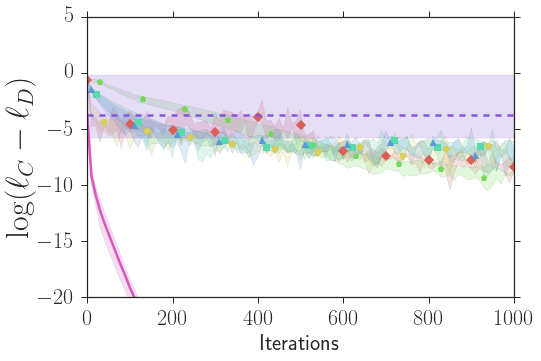

In [203]:
P = [1,2,5,10]
Ps = P
Ns = [100, 1000, 10000]
df = df_from_time(Ps,Ns, alltimeResults05)
n=1000

plt.rc('text', usetex=True)
text = r"$\log(\ell_{C} - \ell_{D})$"



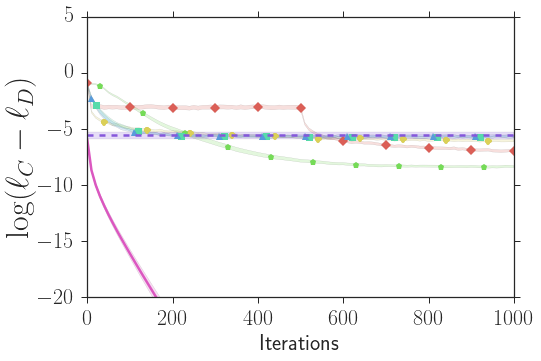

In [190]:
ax = plot_time(df[(df.Size==n) & (df.Covariates==p) & (df.tp<=1000)  & (df.AF<.5)],text,[-20,5], xlim=(0, 1010))

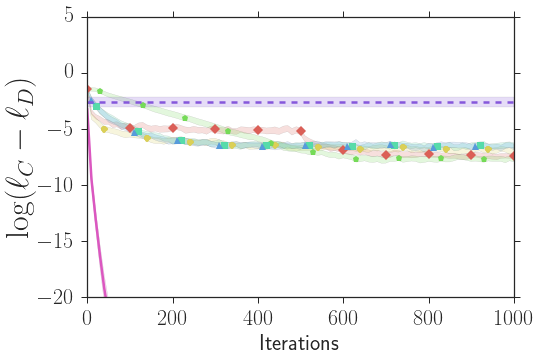

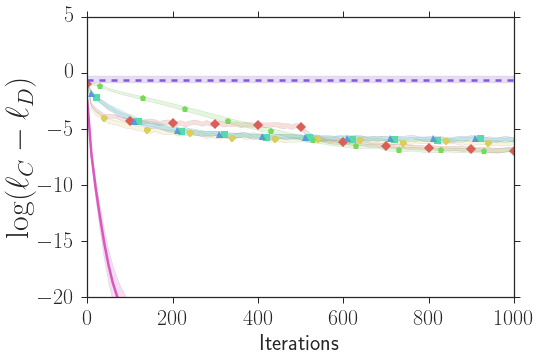

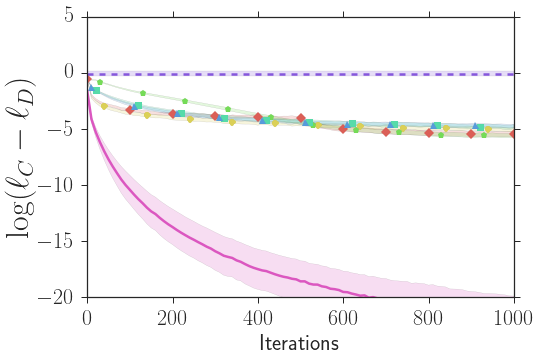

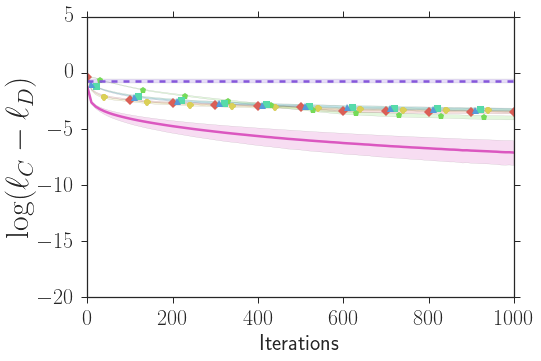

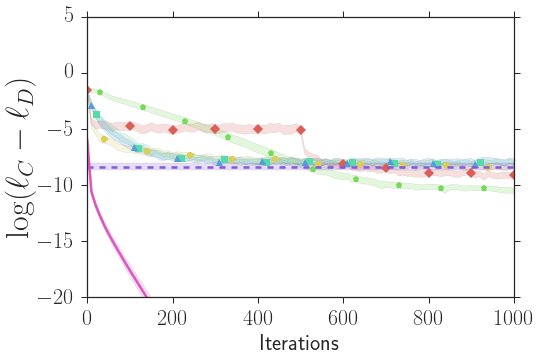

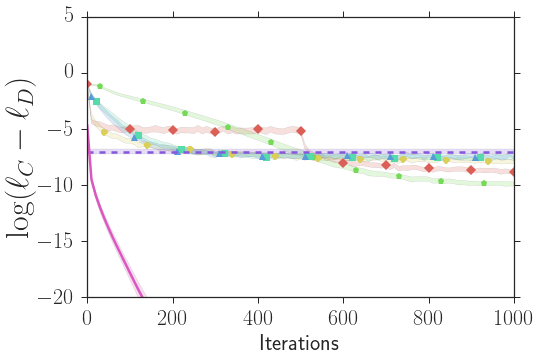

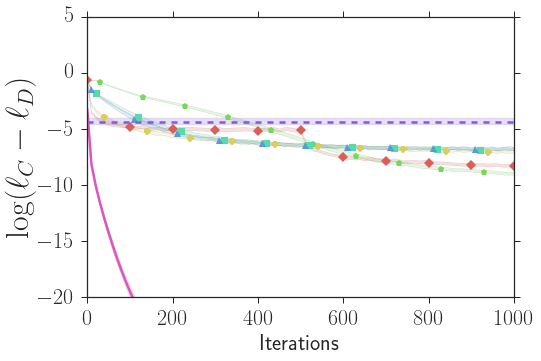

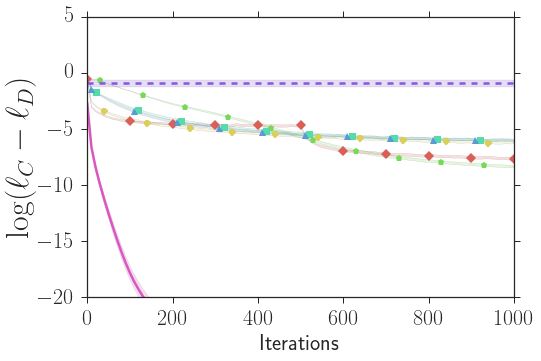

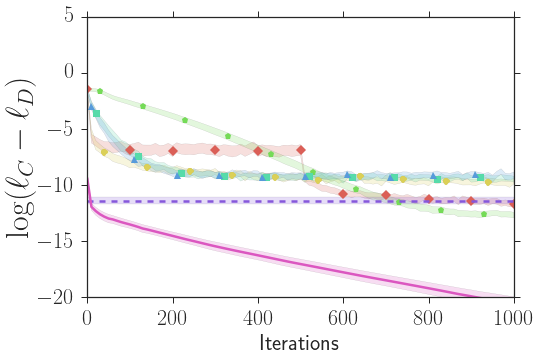

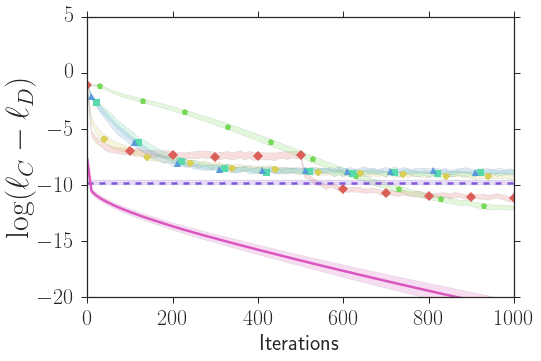

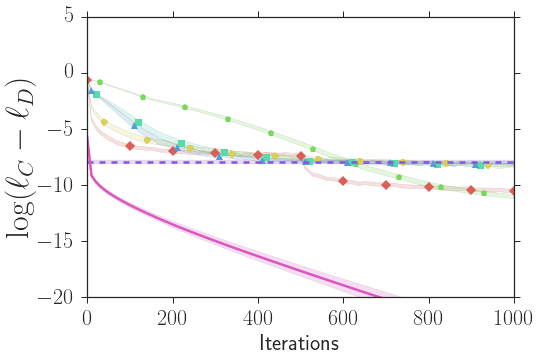

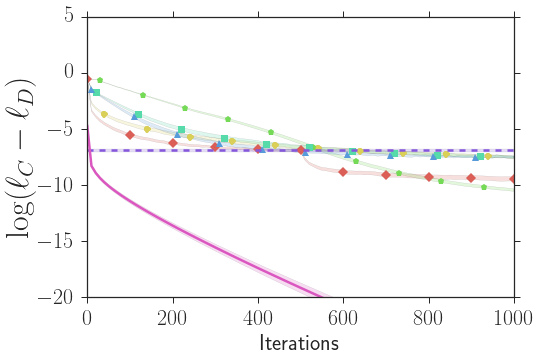

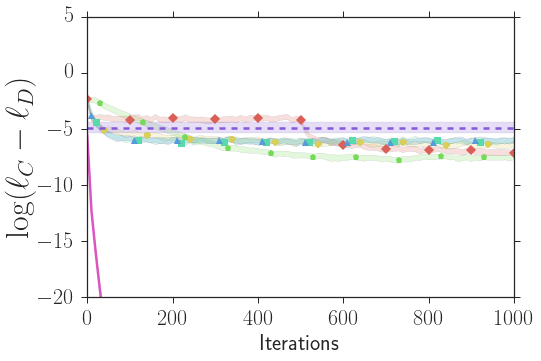

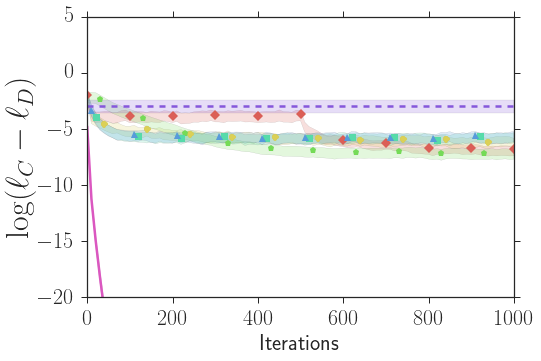

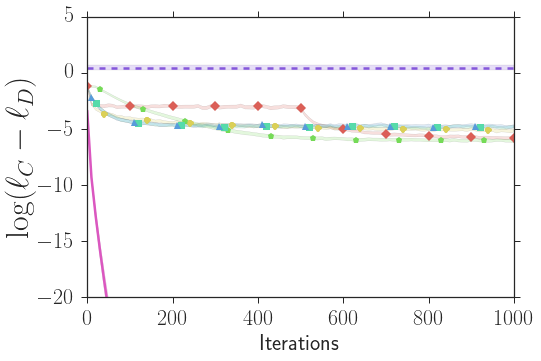

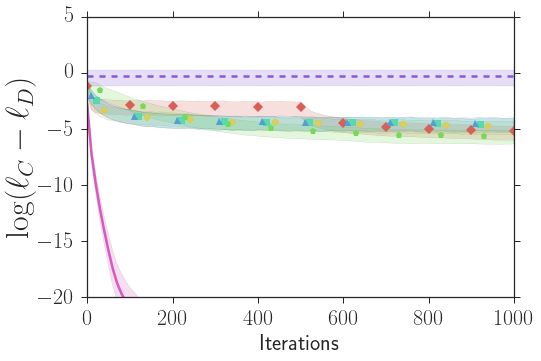

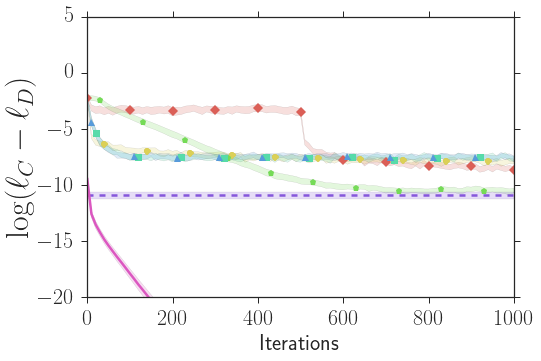

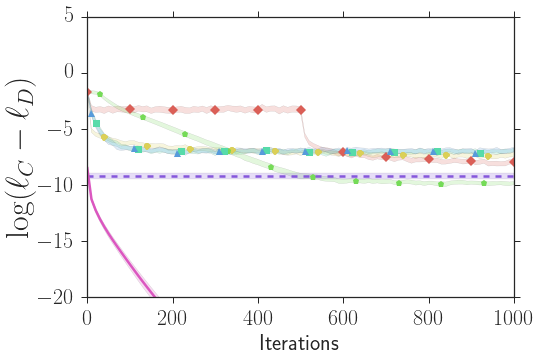

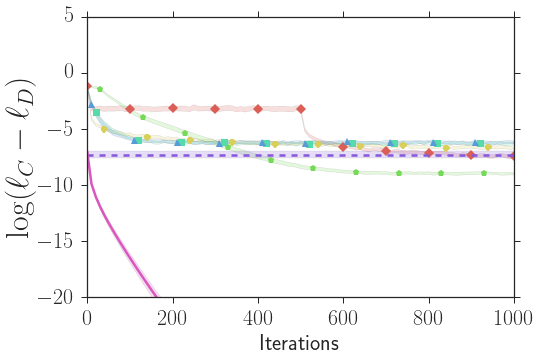

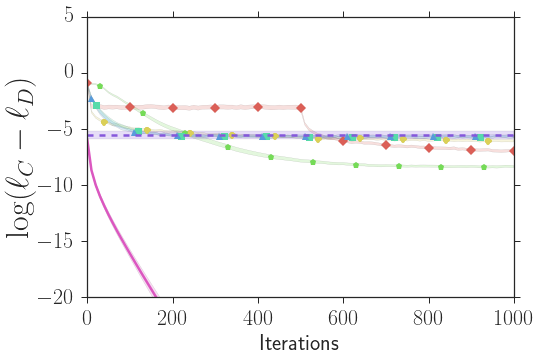

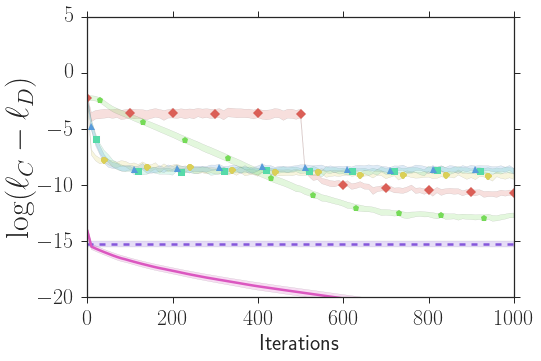

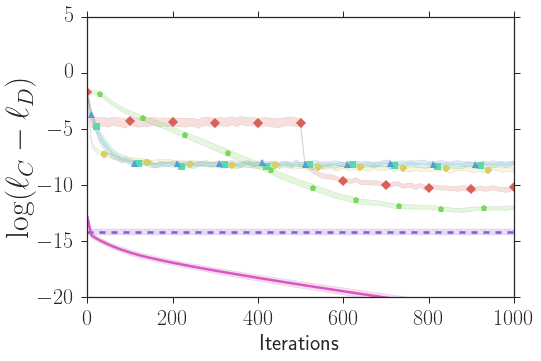

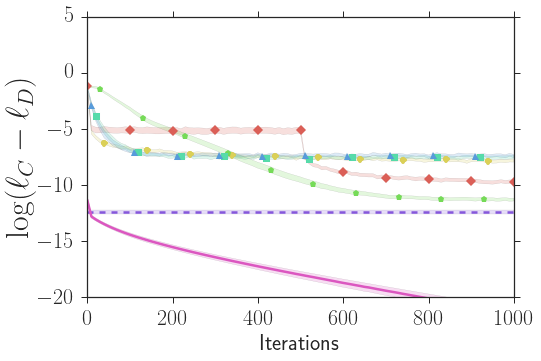

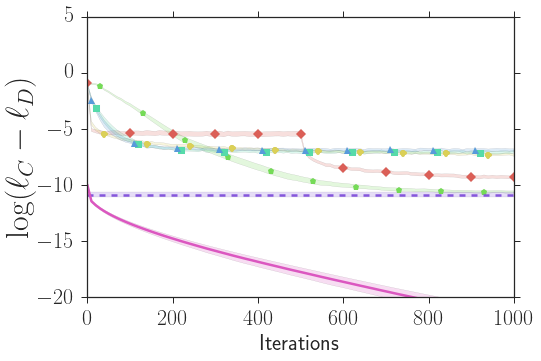

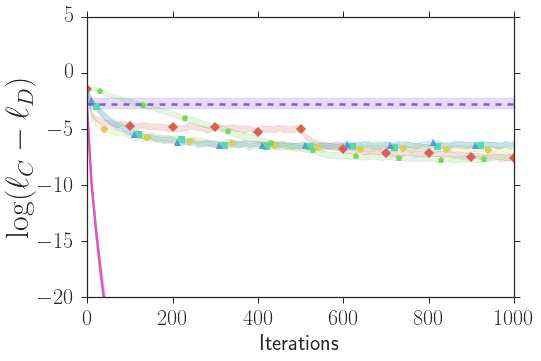

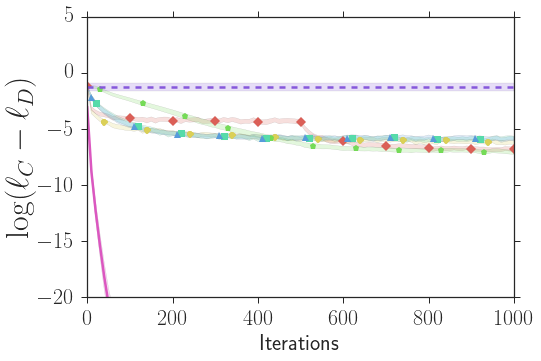

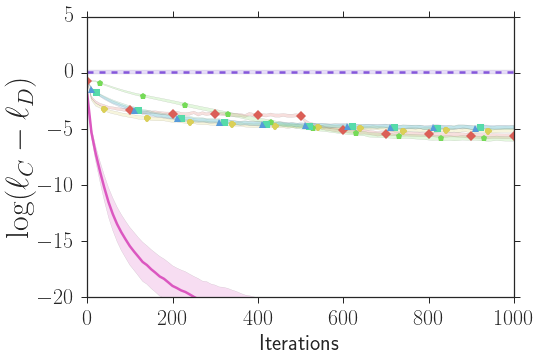

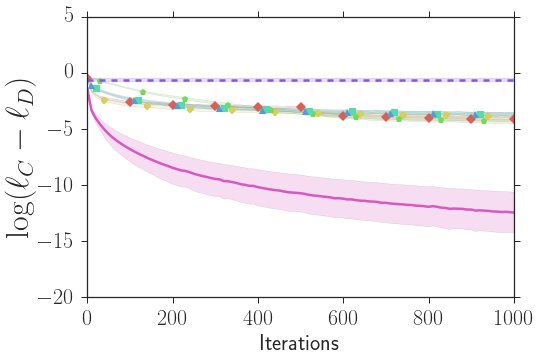

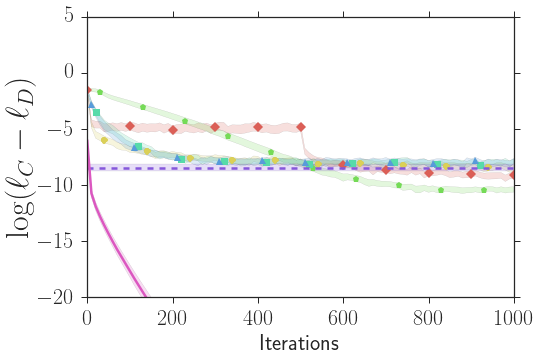

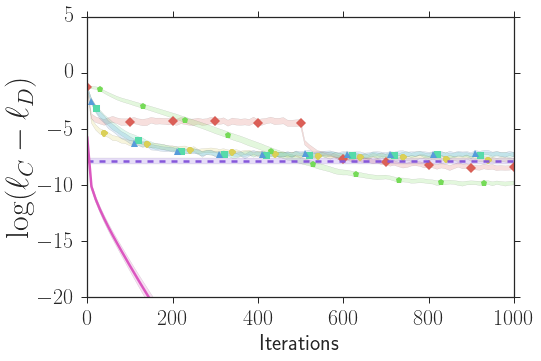

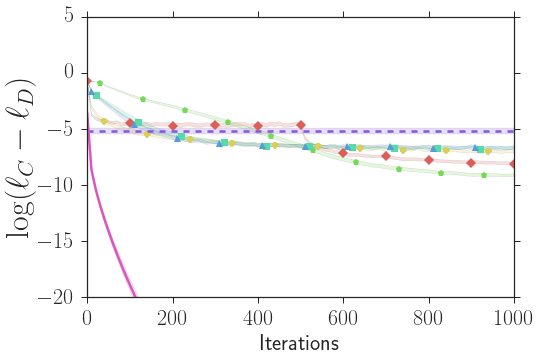

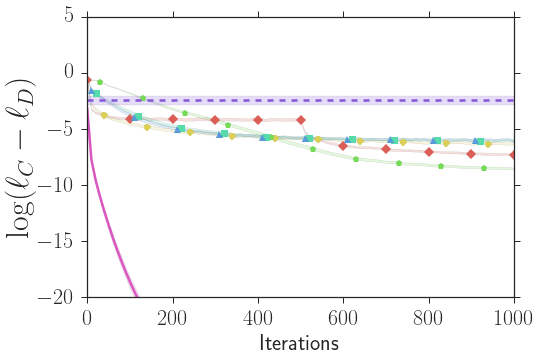

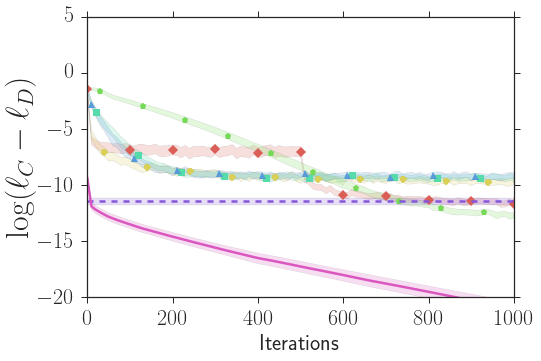

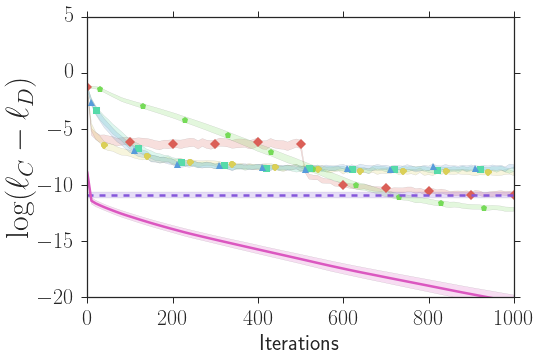

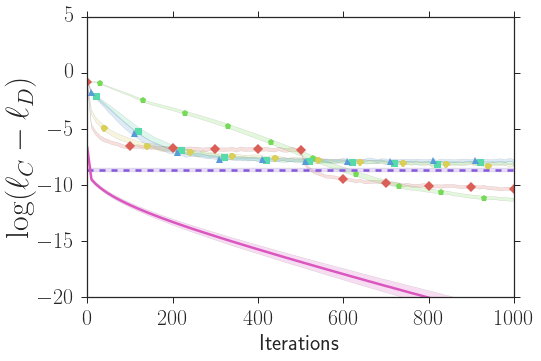

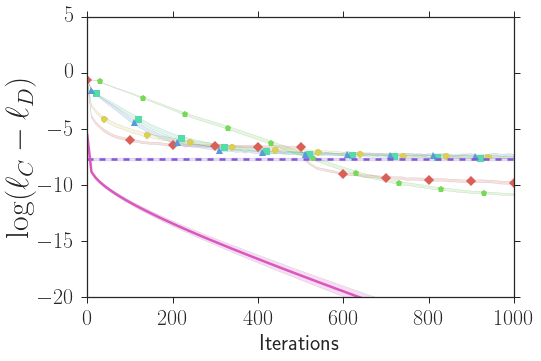

In [157]:
datasets = [alltimeResults0, alltimeResults1, alltimeResults05]
names    = ["alltimeResults0", "alltimeResults1", "alltimeResults05"]
plt.rc('text', usetex=True)
text = r"$\log(\ell_{C} - \ell_{D})$"
# Turn interactive plotting off
plt.ioff()
fig_dir = 'fig/'


for i, dataset in enumerate(datasets):
    df = df_from_time(Ps,Ns, dataset)
    name = names[i]
    for n in Ns:
        for p in Ps: 
            name_arr = [str(n), str(p), name, "cost.png"]
            ax = plot_time(df[(df.Size==n) & (df.Covariates==p) & (df.tp<=1000) ],text,[-20,5], xlim=(0, 1010))
            ax.savefig(fig_dir + "_".join(name_arr), dpi=1200)

plt.ion()

In [133]:

name_arr = [n, p, name]
print ("_".join(name_arr))

100_3_alltimeResults0


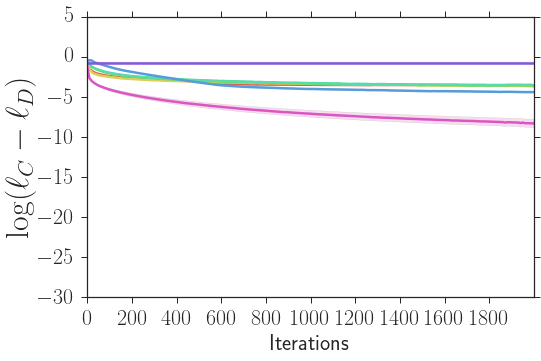

In [326]:
ax = plot_time(df[(df.Size==100) & (df.Covariates==10)],text,[-30,5])

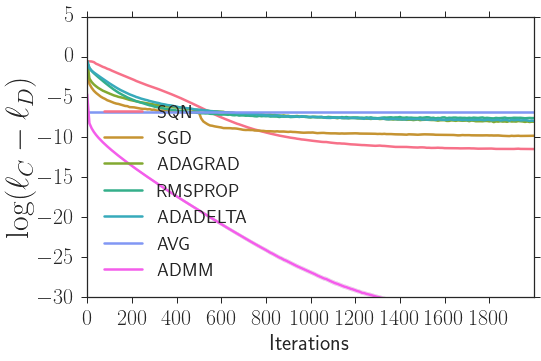

In [295]:
ax = plot_time(df[(df.Size==10000) & (df.Covariates==10)],text,[-30,5])

In [305]:
np.mean(df[(df.Size==100) & (df.variable=='AVG')& (df.Covariates==10)].value)

-0.75837782579506552

In [302]:
df.head(2)

,Size,Covariates,Experiment,tp,variable,value
0,100,1,0,0,SQN,-1.055060
1,100,1,0,10,SQN,-1.098297


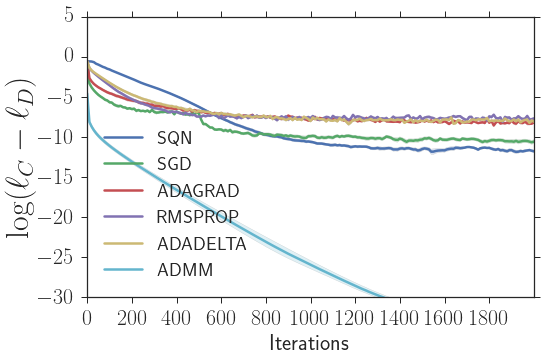

In [206]:
plt.rc('text', usetex=True)

Ps = [1,2,5,10]
Ns = [100, 1000, 10000]
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, p= 'alltimeResults0', 10000, 10
df2 = df_convergance(Ps,Ns, alltimeResults0)
ax = plot_time(df2[(df2.covariates==p)&(df2.n==n) & (df2.variable!='logistic')],text,window)

In [211]:
print df2[df2.tps == 1000].head(2)
df[df.variable=='SQN'].head()

     covariates    n  range   tps variable     value
100           1  100      0  1000      SQN -6.851062
301           1  100      1  1000      SQN -6.751224


,covariates,n,range,loss,variable,value
120,1,100,0,0,SQN,-2.365801
121,1,100,1,0,SQN,-2.929806
122,1,100,2,0,SQN,-4.405403
123,1,100,3,0,SQN,-2.823867
124,1,100,4,0,SQN,-3.913184


In [212]:
np.array(alltimeResults0).shape

(3, 4, 10, 7, 3, 201)

In [226]:
np.array(alltimeResults0)[2,3,:,0,0,100] - np.array(alltimeResults0)[2,3,:,6,0,100]

array([  2.18255061e-05,   3.04604980e-05,   2.08966951e-05,
         1.92447570e-05,   4.56881768e-05,   1.38924343e-05,
         1.77760796e-05,   2.70188731e-05,   1.26927086e-05,
         6.56166365e-05])

In [217]:
np.array(datapn0).shape

(12, 10, 8, 3)

In [231]:
np.array(datapn0)[11,:,1,0] - np.array(datapn0)[11,:,7,0]

array([-10.7121261 , -10.43625015, -10.75843886, -10.73869037,
        -9.9599367 , -11.31164465, -11.00875157, -10.46195423,
       -11.29996534,  -9.6307858 ])

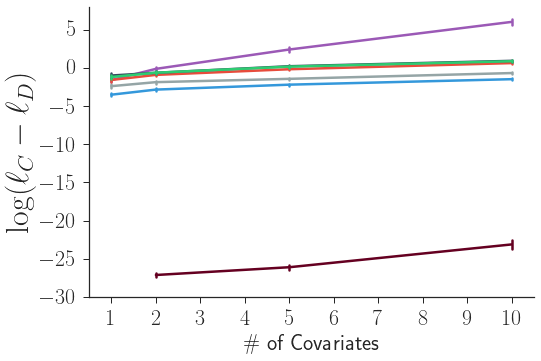

In [169]:
P = [2,3,6,11]
P = P + P + P
N = [100] * 4 + [1000] * 4 + [10000] * 4
df = df_from_pn(P,N, datapn0)
name, n, loss = 'allpnResults0', 1000, 0

plt.rc('text', usetex=True)
text = r"$\log(\ell_{C} - \ell_{D})$"

ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],text,[-30,8])

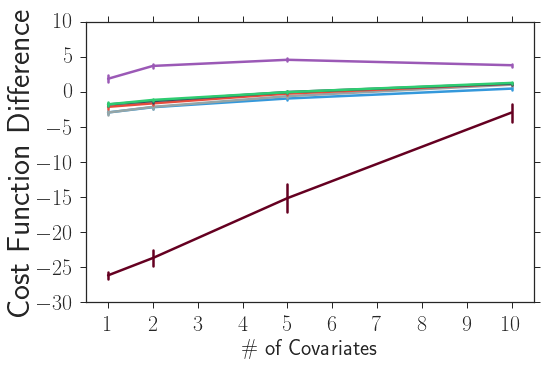

In [160]:
P = [2,3,6,11]
P = P + P + P
N = [100] * 4 + [1000] * 4 + [10000] * 4
df = df_from_pn(P,N, datapn0)
name, n, loss = 'allpnResults0', 100, 0



ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],'Cost Function Difference',[-30,10])

# Test for PCA method

In [2]:
m = np.hstack((np.random.normal(0,10,(30,20)), np.random.poisson(10,(30,20))))
U, s, V = np.linalg.svd(m, full_matrices=True);
m1 = m[:10,:]; m2 = m[10:20,:]; m3 = m[20:30,:]

combined = m1.T.dot(m1) + m2.T.dot(m2) + m3.T.dot(m3)
_, eVals, eVecs = np.linalg.svd(combined)
eVecs = np.array([v for _,v in sorted(zip(eVals,eVecs),key=lambda l: l[0])][::-1])
eVals = np.array(sorted(eVals)[::-1])
#U1, s1, V1 = np.linalg.svd(m.T, full_matrices=True)

In [ ]:
print np.abs(np.sqrt(eVals[eVals>1e-5]) - s) < 1e-6
# So the sigmas are the same
a = eVecs + V
aprime = eVecs - V
t = 0.001
print (np.logical_or(np.sqrt(np.sum(a**2, axis=1)) < t, np.sqrt(np.sum(aprime**2,axis=1)) < t))
# the or is to account for possible sign changes. So far, sigma and V match, it's left to see if we can reconstruct
# U. The False ones correspond to eigenvalue 0 so they don't matter 

In [ ]:
is1, iV1 = np.linalg.inv(np.diag(eVals)), eVecs.T

Um1 = is1.dot(iV1).dot(m1.T).T
Um2 = is1.dot(iV1).dot(m2.T).T
Um3 = is1.dot(iV1).dot(m3.T).T
s = np.array(list(s) + [0 for _ in range(U.shape[1] - s.shape[0])])

In [ ]:
np.sum(np.abs(Um1.dot(np.diag(eVals)).dot(eVecs.T) - U[:10,:].dot(np.diag(s)[:,:V.shape[0]]).dot(V[:U.shape[0]])))

# Offline

In [ ]:
def batch_stepsize_test(totCount, dim, totDOs,f, bs, hs,x, eta): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%42949672951235641343*x%4294967295)
    beta = np.random.normal(0,1,dim + 1)
    print (beta)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
    center = DataCenter(dim)
    for i, n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_regression(center)
    betas = np.zeros((6,betaL.shape[0]))
    
    betas[0,:] = center.SQN(50,10,eta,bs,hs, max_iters=1000).ravel() #SQN beta
    betas[1,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=eta)[0]      # simple sgd 
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=1, step=eta)[0]    #adagrad 
    #betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=2, step=eta)[0]     #rms prop 
    #betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, stepAlg=3, step=eta)[0]     #adadelta 
    betas[3,:] = center.avgLogistic()
    betas[4,:] = center.ADMM(1.0, max_iters=1000)
    
    costs = np.zeros((7,3))
    for i in xrange(5):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[5,:] = cost, roc, zeroone
    return costs

## Find optimal stepsize 

In [24]:
#%%cache logstepsize.pkl stepsizeData 
etas = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeData = []
Ns = [1000, 10000]
bs = [0.1, 0.2]
hs = [0.25, 0.5]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        f = lambda x: batch_stepsize_test(x[1],x[2],5,0, x[3], x[4],x[0],x[5])
        keywords = zip([int(j*hs[i]*nnum*seed) for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeData.append(results)
        tend = time()
        print i, eta, '\n'
        sys.stdout.flush()
print time()-t0

7.20024108887e-05 

0.000126838684082 

9.79900360107e-05 

9.17911529541e-05 

9.20295715332e-05 

9.20295715332e-05 

0.000118970870972 

9.48905944824e-05 

0.000164985656738 

8.98838043213e-05 

9.89437103271e-05 

8.70227813721e-05 

0.000102996826172 

0.000121116638184 

9.20295715332e-05 

8.29696655273e-05 

0.00929379463196


In [28]:
f(keywords[6])

array([[        nan,         nan,         nan],
       [ 0.15079158,  0.98643509,  0.0635    ],
       [ 0.15758535,  0.98570295,  0.066     ],
       [ 1.90279482,  0.94554733,  0.0785    ],
       [ 2.23214394,  0.93406683,  0.0871    ],
       [ 0.14853609,  0.98644513,  0.0637    ]])

In [ ]:
totDOs = 5
def offline(totCount, p, totDOs,f, bs, hs,x, eta): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((8,betaL.shape[0]))
    
    #betas[0,:] = center.avgLogistic()     # averaging 
    #betas[1,:] = center.SQN(50,10,eta,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=eta)[0]      # simple sgd 
    #betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=eta)[0]    #adagrad 
    #betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=eta)[0]     #rms prop 
    #betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=eta)[0]     #adadelta 
    #betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

etas = [500.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeData = []
Ns = [1000, 10000]
bs = [20,50]
hs = [50,500]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0, x[3], x[4],x[0],x[5])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeData.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache logstepsizeDisc.pkl stepsizeDataDisc 
etas = [0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0]
s = "step"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
stepsizeDataDisc = []
Ns = [1000, 10000]
bs = [20,50]
hs = [50,500]
pnum = 5
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for eta in etas:
        nnum= Ns[i]
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0],x[5])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps,[eta]*reps)
        results=p.map(f, keywords)
        stepsizeDataDisc.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

## best parameters are: sqn sgd ada rms adadelta
Observations:
* Regular SGD is highly sensitive the rest are not very sensitive 
Step-sizes 
.01,10,5,.05,.1

In [ ]:
totDOs = 5
def offline(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((7,betaL.shape[0]))
    
    betas[0,:] = center.avgLogistic()     # averaging 
    betas[1,:] = center.SQN(50,10,.01,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=200.0)[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=5.0)[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=0.05)[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=.1)[0]     #adadelta 
    betas[6,:] = center.ADMM(1.0, max_iters=1000)    # admm 
    costs = np.zeros((8,3))
    for i in xrange(7):
        costs[i,:] = center.evaluate(betas[i,:])
    costs[7,:] = cost, roc, zeroone
    return costs

In [ ]:
df = pd.DataFrame(data=stepsizeData[7], columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
offline(1000, 6, totDOs,0.0, 20, 50,311313,50.0)

In [ ]:
df = pd.DataFrame(data=results, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','ADMM']], columns= ['AVG', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(45141241)
repeats = 100
C1 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C1[i,:] = offline(10000,5,2,1,50,500)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C1, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','SQN','ADMM', 'ADAGRAD','RMSPROP']], columns= ['AVG','ADMM', 'SQN','ADAGRAD','RMSPROP'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C2 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C2[i,:] = offline(1000,5,2,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C2, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['AVG','ADMM']], columns= ['AVG', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C3 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C3[i,:] = offline(1000,5,6,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=C3, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
df = pd.DataFrame(data=df[['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']], columns= 
                  ['SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
np.random.seed(321323)
repeats = 100
C4 = np.empty((repeats,8))
tstart = time()
for i in range(repeats):
    C4[i,:] = offline(1000,5,11,0,5,50)
tend = time()
print tend-tstart

In [ ]:
df = pd.DataFrame(data=allpnResults0[7], columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic'])
df = pd.DataFrame(data=df.subtract(df.logistic,axis=0), columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM'])
ax = sns.boxplot(data=df, palette="PRGn")
ax.set(xlabel='Algorithms', ylabel='cross-entropy (centered)')
sns.despine(offset=10, trim=True)
plt.show()

# p 1,2,5,10, N with 5 bins

In [ ]:
%%cache allpnResults0.pkl allpnResults0 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults0 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults0.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allpnResults1.pkl allpnResults1 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults1 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults1.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allpnResults0.5.pkl allpnResults05
s = "PNexp05"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults05.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
allpnResults0 = np.array(allpnResults0)
print allpnResults0.shape
dat = allpnResults0

In [ ]:
def df_from_pn(P,N, sim, DO=5):
    df = pd.DataFrame()
    result = pd.DataFrame()
    sim = np.array(sim)
    loss = ['cost', 'roc', '01']
    for i in range(3):
        for data in range(sim.shape[0]):
            p = P[data]
            n = N[data]
            cov = np.array([p-1]*sim.shape[1])
            cov.shape = (100,1)
            size = np.array([n]*sim.shape[1])
            size.shape = (100,1)
            r = np.array(range(100))
            r.shape = (100,1)
            l = np.array([i]*100)
            l.shape = (100,1)
            appended = np.hstack((sim[data,:,:,i],cov,size,r,l))
            if i == 0:
                appended = np.hstack((sim[data,:,:,i]*n,cov,size,r,l))
            else:
                appended = np.hstack((sim[data,:,:,i],cov,size,r,l))     
            df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n', 'range','loss']))
    
    df1 = df.loc[df.loss==0]
    df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0))
    #df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]).div(df1['logistic']+ 10**-10, axis=0)
    df.loc[df.loss==0, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = np.log(np.abs(df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]))
    
    df1 = df.loc[df.loss==2]
    df.loc[df.loss==2, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].div(
        df1.logistic, axis=0)
    #df.drop("logistic", axis=1,inplace=True)
    
    df = pd.melt(df, id_vars=["covariates","n",'range', 'loss'])
    ####### TODO evaluate globally not locally 
    df = df[~np.isnan(df.value)]
    return df
    

In [ ]:
def plot_pn(df,ylab,ylim):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df,color=colors,  err_style="ci_bars",ax=ax
           ,interpolate=True,legend=False)
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('\# of Covariates', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=0)
    #ax.yaxis.set_label_coords(-.09, -.2)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(0.5, 10.5)  # outliers only
    plt.legend(loc='best')
    #ax.set(xticks=np.arange(1,10,2))
    ax.set_xticks(np.arange(1,10,2))
    ax.tick_params(labelsize=22)
    sns.set_style("ticks")
    plt.tight_layout()
    return f

In [ ]:
df = pd.DataFrame()
allpnResults0 = np.array(dat)
P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4 
loss = ['cost', 'roc', '01']
i=0
for data in range(12):
    p = P[data]
    n = N[data]
    cov = np.array([p-1]*allpnResults0.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults0.shape[1])
    size.shape = (100,1)
    r = np.array(range(100))
    r.shape = (100,1)
    appended = np.hstack((allpnResults0[data,:,:,i],cov,size,r))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n', 'range']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)

In [ ]:
allpnResults0 = np.array(dat)
allpnResults0.shape

In [ ]:
df = pd.melt(df, id_vars=["covariates","n",'range'])

In [ ]:

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)].drop("n", axis=1,inplace=False),color=colors,  err_style="ci_bars",ax=ax, 
           interpolate=False)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)].drop("n", axis=1,inplace=False),color=colors,  err_style="ci_bars",ax=ax2
          ,legend=False, interpolate=True)

ax.axes.get_xaxis().set_visible(False)  #turnoff xaxis label for top graph
ax2.yaxis.label.set_visible(False)


ax.set_ylim(.05, .8)  # outliers only
ax2.set_ylim(0, .04)  # most of the data
ax.set_xlim(0, 10.5)  # outliers only
ax2.set_xlim(0, 10.5)  # most of the data
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)

ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel('# of Covariates', fontsize=18)
ax.set_ylabel('Cost Function Difference', fontsize=16)
ax.yaxis.set_label_coords(-.09, -.2)
sns.plt.show()

In [ ]:
f, (ax) = plt.subplots(1, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==100)],color=colors,  err_style="ci_bars",ax=ax
           ,interpolate=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.xlabel('# of Covariates', fontsize=18)
ax.set_ylabel('Cost Function Difference', fontsize=16)
#ax.yaxis.set_label_coords(-.09, -.2)
ax.set_ylim(0, .03)  # most of the data
ax.set_xlim(0.5, 10.5)  # outliers only
plt.legend(loc='best')
ax.set(xticks=np.arange(1,10,2))

sns.plt.show()

In [ ]:
P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4

name, n, loss = 'allpnResults0', 100, 0
df = df_from_pn(P,N, allpnResults0)
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')& (df.range != 67)],'Cost Function Difference',[-20,5])
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

In [ ]:
dat = np.array(allpnResults0).shape

In [ ]:
name, n, loss = 'allpnResults1', 100, 0
df = df_from_pn(P,N, allpnResults1)
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic') & (df.range!=41) & (df.range != 88) ],'Cost Function Difference',[-0.005,.03])

In [ ]:
#Plotting 
plt.rc('text', usetex=True)

P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, loss = 'allpnResults0', 1000, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)

ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults0', 10000, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults0', 100, 0
df = df_from_pn(P,N, allpnResults0)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic') & (df.range != 67)]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

#  this one needs special attention, one of the values ended up being nan, so we will delete that and relvant counts

name, n, loss = 'allpnResults1', 1000, 0
df = df_from_pn(P,N, allpnResults1)
df = df[(df.n==1000)& (df.loss==loss)& (df['range']!=79)]
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults1', 10000, 0
df = df_from_pn(P,N, allpnResults1)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

# name, n, loss = 'allpnResults1', 100, 0
# df = df_from_pn(P,N, allpnResults1)
# df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')& (df.range!=41) & (df.range != 88)]
# df1.value[np.isneginf(df1.value)] = np.nan 
# df1['value'].fillna((df1['value'].mean()), inplace=True)
# ax = plot_pn(df1,text,window)
# ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")


name, n, loss = 'allpnResults05', 1000, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults05', 10000, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

name, n, loss = 'allpnResults05', 100, 0
df = df_from_pn(P,N, allpnResults05)
df1 = df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')]
df1.value[np.isneginf(df1.value)] = np.nan 
df1['value'].fillna((df1['value'].mean()), inplace=True)
ax = plot_pn(df1,text,window)
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")



# Time to convergence 

In [ ]:
totDOs = 5
def timeoffline(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
        
    iters = 1000
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((7,betaL.shape[0],iters/10+1))
    
    #betas[0,:,:] = center.avgLogistic()     # averaging 
    betas[1,:,:] = center.SQN(50,10,.01,bs,hs, max_iters=iters,verbose=True)   #SQN beta
    betas[2,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, step=200.0,verbose=True)     # simple sgd 
    betas[3,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=1, step=5.0,verbose=True)   #adagrad 
    betas[4,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=2, step=0.05,verbose=True)    #rms prop 
    betas[5,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=3, step=.1,verbose=True)     #adadelta 
    betas[6,:,:] = center.ADMM(1.0, max_iters=iters,verbose=True)    # admm 
    costs = np.zeros((8,3,iters/10+1))
    for i in xrange(7):
        for j in xrange(iters/10+1):
            costs[i,:,j] = center.evaluate(betas[i,:,j])
    for j in xrange(iters/10+1):
        costs[7,:,j] = cost, roc, zeroone
    return costs

In [ ]:
%%cache alltimeResults0.pkl alltimeResults0 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults0 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults0.append(temp)
print time()-t0

In [ ]:
%%cache alltimeResults1.pkl alltimeResults1 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults1 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,1.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults1.append(temp)
print time()-t0

In [ ]:
%%cache alltimeResults05.pkl alltimeResults05 
s = "PNexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
alltimeResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        f = lambda x: timeoffline(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    alltimeResults05.append(temp)
print time()-t0

In [ ]:
reps = 100
alltimeResults05 = []
Ps = [1,2,5,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)

In [ ]:
np.array(alltimeResults0).shape

In [ ]:
def df_convergance(P,N, sim, DO=5):
    df = pd.DataFrame()
    sim = np.array(sim)
    exps = sim.shape[2]
    tp = sim.shape[5]
    reshaped = np.empty((exps * tp,10))

    for k in range(1):
        for i,n in enumerate(N):
            for j,p in enumerate(P):
                for l in range(exps):
                    reshaped[l*tp:((l+1)*tp),:8] = sim[i,j,l,:,k,:].T
                    reshaped[l*tp:((l+1)*tp),8] = [l]*tp
                    reshaped[l*tp:((l+1)*tp),9] = range(0,tp*10,10)
                cov = np.array([p-1]*exps*tp,ndmin=2).T
                size = np.array([n]*exps*tp,ndmin=2).T
                #timepoint = np.array([np.array(range(100))]*tp,ndmin=2).reshape(10100,1)
                r = np.repeat(range(tp),exps).reshape(tp*exps,1)
                #l = np.array([i]*100,ndmin=2).T
                appended = np.hstack((reshaped,cov,size))
                df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM',
                                                                 'logistic', 'range', 'tps','covariates','n']))
    df1 = df
    df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0))
    #df1 = (df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]).div(df1['logistic']+ 10**-10, axis=0)
    df.loc[:, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]
    df = pd.melt(df, id_vars=["covariates","n",'range','tps'])
    logs = np.log(df.value)
    df.value = logs
    df.value[np.isnan(logs) & ~np.isfinite(logs)] = min(logs[~np.isnan(logs) & np.isfinite(logs)])
    return df

In [ ]:
def plot_time(df,ylab,ylim):
    f, (ax) = plt.subplots(1, 1, sharex=True)
    sns.tsplot(time="tps", value="value", condition="variable",
           unit="range",data=df,color=colors[1:],  err_style="ci_band",ax=ax
           ,interpolate=True,legend=False)
    sns.set_context("notebook", font_scale=1.9, rc={"lines.linewidth": 2.5})
    plt.xlabel('Iterations', fontsize=22)
    ax.set_ylabel(ylab, fontsize=32, labelpad=-2)
    #ax.yaxis.set_label_coords(-.09, -.2)
    ax.set_ylim(ylim)  # most of the data
    ax.set_xlim(0, 1000)  # outliers only
    plt.legend(loc='best')
    ax.set_xticks(np.arange(0,1000,100))
    ax.tick_params(labelsize=22)
    sns.set_style("ticks")
    plt.tight_layout()
    return f

In [ ]:
df = df_convergance(Ps,Ns, alltimeResults05)

In [ ]:
plt.rc('text', usetex=True)

P = [2,3,6,11]
P = P + P + P
N = [1000] * 4 + [10000] * 4 + [100] * 4
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]


plot_time(df[(df.covariates==4)&(df.n==1000) & (df.variable!='logistic')],text,window)

In [ ]:
#Plotting 
plt.rc('text', usetex=True)

Ps = [1,2,5,10]
#N = [1000] * 4 + [10000] * 4 + [100] * 4
Ns = [1000, 10000, 100]
text = r"$\log(\ell_{C} - \ell_{D})$"
window = [-30,5]

name, n, p= 'alltimeResults1', 1000, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

name, n, p= 'alltimeResults1', 10000, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

name, n, p= 'alltimeResults1', 100, 4
df = df_convergance(Ps,Ns, alltimeResults1)
ax = plot_time(df[(df.covariates==p)&(df.n==n) & (df.variable!='logistic') & (df.variable!='AVG')],text,window)
ax.savefig(figSaveFile+str(p)+name+"_"+str(n)+".png")

In [ ]:
f, (ax) = plt.subplots(1, 1, sharex=True)
sns.tsplot(time="covariates", value="value", condition="variable",
           unit="range",data=df[(df.n==1000)& (df.loss==loss)& (df['range']>80)],color=colors,  err_style="ci_bars",ax=ax
          ,interpolate=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax.set_xlim(0.5, 10.5)  # outliers only
ax.set_ylim(-0.001, .03) 



In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", data=df[(df.variable!="AVG") & (df.n==1000)]
               ,palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p0_1000.png")

In [ ]:
ind = [1,3,6]
sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.variable!="RMSPROP") &(df.variable!="SGD") 
                       &(df.variable!="ADADELTA") &(df.variable!="AVG") & (df.n==1000)],
               palette=colors[ind])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p0_10000.png")

In [ ]:
ind=[0,2,3,6]
sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)&(df.variable!="SGD")&(df.variable!="ADADELTA")&(df.variable!="RMSPROP")],
               palette=colors[ind])

In [ ]:
totDOs = 5
def timejustone(totCount, p, totDOs,f, bs, hs,x): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    #pdb.set_trace()
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
        
    iters = 10000
    center.count_data()
    center.scale()
    betaL,cost,roc, zeroone = all_logistic(center)
    betas = np.zeros((2,betaL.shape[0],iters/10+1))
    
    #betas[0,:,:] = center.avgLogistic()     # averaging 
    #betas[1,:,:] = center.SQN(50,10,.01,bs,hs, max_iters=iters,verbose=True)   #SQN beta
    #betas[2,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, step=200.0,verbose=True)     # simple sgd 
    betas[0,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=1, step=5.0,verbose=True)   #adagrad 
    #betas[4,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=2, step=0.05,verbose=True)    #rms prop 
    #betas[5,:,:] = center.batch_SGD(bs,0.0001, max_iters=iters, adagrad=3, step=.1,verbose=True)     #adadelta 
    #betas[6,:,:] = center.ADMM(1.0, max_iters=iters,verbose=True)    # admm 
    costs = np.zeros((2,3,iters/10+1))
    for i in xrange(1):
        for j in xrange(iters/10+1):
            costs[i,:,j] = center.evaluate(betas[i,:,j])
    for j in xrange(iters/10+1):
        costs[1,:,j] = cost, roc, zeroone
    return costs

In [ ]:
s = "test"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
longtest= []
Ps = [2,10]
Ns = [1000, 10000, 100]
bs = [20,50,2]
hs = [50,500,5]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(3):
    temp = []
    for pnum in Ps:
        nnum= Ns[i]
        print pnum
        f = lambda x: timejustone(x[1],x[2]+1,5,0.5, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        temp.append(results)
        sys.stdout.flush()
    longtest.append(temp)
print time()-t0

## Half and half

In [ ]:
df = pd.DataFrame()
allpnResults05 = np.array(allpnResults05)
P = [2,3,6,11]
P = P + P
N = [1000] * 4 + [10000] * 4

for data in range(8):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults05.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults05.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults05[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==1000)&(df.variable!="AVG")],
               palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p05_1000.png")

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p05_10000.png")

## All dosage 

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allpnResults1)
P = [2,3,6,11]
P = P + P
N = [1000] * 4 + [10000] * 4

for data in range(8):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==1000)&(df.variable!="AVG")],
               palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p1_1000.png")

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", 
               data=df[(df.n==10000)],
               palette=colors, legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"p1_10000.png")

# P2,5  N=1000: 10,000; 3,5,7,9

In [ ]:
%%cache allnResults0.pkl allnResults0
s = "repoexp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults0 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.0, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults0.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allnResults05.pkl allnResults05
s = "repo5exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults05 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults05.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
%%cache allnResults1.pkl allnResults1
s = "rep1exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults1 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 10000
bs = 50
hs = 500
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(10000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults1.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults0)[:,:,:,0]
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==11)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p11_type0_size_10000.png")

In [ ]:
def df_from_results(P,N, sim, DO=[]):
    df = pd.DataFrame()
    result = pd.DataFrame()
    sim = np.array(sim)
    loss = ['cost', 'roc', '01']
    exps = sim.shape[0]
    if len(DO) == 0:
        DO = [5] * exps 
    for i in range(3):
        for data in range(exps):
            p = P[data]
            n = N[data]
            do = DO[data]
            cov = np.array([p-1]*sim.shape[1],ndmin=2).T
            size = np.array([n]*sim.shape[1],ndmin=2).T
            r = np.array(range(100),ndmin=2).T
            l = np.array([i]*100,ndmin=2).T
            num_do = np.array([do]*100,ndmin=2).T
            appended = np.hstack((sim[data,:,:,i],cov,size,r,l,num_do))
            df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM',
                                                                 'logistic','covariates','n', 'range','loss','do']))
    df1 = df.loc[df.loss==0]
    df1 = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df1['logistic'], axis=0)
    df.loc[df.loss==0, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']]
    
    df1 = df.loc[df.loss==2]
    df.loc[df.loss==2, ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 
                                                                                               'ADMM']].div(df1.logistic, axis=0)
    #df.drop("logistic", axis=1,inplace=True)
    df = pd.melt(df, id_vars=["covariates","n",'range', 'loss', 'do'])
    return df

In [ ]:
#Plotting 
P = [2,3,6,11]
P = P + P + P + P
N = [10000] * 16
DO = np.sort(RepoSize * 4)
df = df_from_results(P,N, allnResults0, DO=DO)

name, n, loss = 'allpnResults0', 1000, 0
ax = plot_pn(df[(df.n==n) & (df.loss==loss)& (df.variable!='logistic')],'Cost Function Difference',[-0.005,.03])
ax.savefig(figSaveFile+"p_"+name+"_"+str(n)+"_"+str(loss)+".png")

In [ ]:
np.sort(RepoSize * 4)

In [ ]:
a = np.array([5]*100,ndmin=2).T
print a.shape

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults05)
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==2)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p2_type05_size_10000.png")

In [ ]:
%%cache allnResults05_1000.pkl allnResults05_1000
s = "repo5exp"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allnResults05_1000 = []
Ps = [1,2,5,10]
RepoSize = [3,5,7,9]
nnum = 1000
bs = 20
hs = 50
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(len(RepoSize)):
    for pnum in Ps:
        s = RepoSize[i]
        print s, '\n'
        tstart = time()
        f = lambda x: offline(1000,x[2]+1,x[1],0.5, x[3], x[4],x[0])
        keywords = zip([j*hs*RepoSize[i]*pnum*seed for j in inputs],[s]*reps, 
                       [pnum]*reps, [bs]*reps, [hs]*reps)
        results=p.map(f, keywords)
        allnResults05_1000.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults1 = np.array(allnResults05_1000)
P = [2,3,6,11]
P = P + P + P + P 
N = np.repeat(RepoSize,4)

for data in range(16):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults1.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults1.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults1[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="n", y="value", hue="variable", 
               data=df[(df.covariates==2)],
               palette=colors, legend=True)
ax.despine(left=True)
#plt.legend(loc='right')
ax.set(xlabel="# of DO's", ylabel='Cross-entropy difference')
ax.savefig(figSaveFile+"repos_p2_type05_size_1000.png")

# Extreme cases

In [ ]:
%%cache allpnResults0_100.pkl allpnResults0_100
s = "PNexp0100"
seed = int(''.join(str(ord(c)) for c in s))%4294967295
reps = 100
allpnResults0_100 = []
Ps = [1,2,5,10]
Ns = [100]
bs = [5]
hs = [10]
p = Pool(4)
inputs=range(1,reps+1)


t0 = time()
for i in xrange(2):
    for pnum in Ps:
        nnum= Ns[i]
        print pnum, '\n'
        tstart = time()
        f = lambda x: offline(x[1],x[2]+1,5,0.0, x[3], x[4],x[0])
        keywords = zip([j*hs[i]*nnum*seed for j in inputs],[nnum]*reps, 
                       [pnum]*reps, [bs[i]]*reps, [hs[i]]*reps)
        results=p.map(f, keywords)
        allpnResults0_100.append(results)
        tend = time()
        print tend-tstart, '\n'
        sys.stdout.flush()
print time()-t0

In [ ]:
df = pd.DataFrame()
allpnResults05 = np.array(allpnResults0_100)
P = [2,3,6,11]
P = P 
N = [100] * 4 

for data in range(4):
    p = P[data]
    n = N[data]
    cov = np.array([p]*allpnResults05.shape[1])
    cov.shape = (100,1)
    size = np.array([n]*allpnResults05.shape[1])
    size.shape = (100,1)
    appended = np.hstack((allpnResults05[data],cov,size))
    df = df.append(pd.DataFrame(data=appended, columns= ['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM','logistic','covariates','n']))
df1 = df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']].sub(df['logistic'], axis=0)
df[['AVG', 'SQN', 'SGD', 'ADAGRAD', 'RMSPROP', 'ADADELTA', 'ADMM']] = df1
df.drop("logistic", axis=1,inplace=True)
df = pd.melt(df, id_vars=["covariates","n"])

In [ ]:
ax = sns.factorplot(x="covariates", y="value", hue="variable", data=df[(df.variable!="AVG") & (df.n==100)]
               ,palette=colors[1:], legend=False)
ax.despine(left=True)
plt.legend(loc='upper left')
ax.set(xlabel='# of covariates', ylabel='Cross-entropy difference')
#ax.savefig(figSaveFile+"p0_1000.png")

# Linear Regression

In [ ]:
totDOs = 5
def offlineLasso(totCount, p, totDOs,f, bs, hs,x,logistic=False): # f is for fraction of categorical covariates 
    np.random.seed(1235641343*x%4294967295)
    dim = p - 1
    beta = np.random.normal(0,1,p)
    #beta[0] = 0
    DOs = []
    num = None
    # check that no DO gets less than 10% of the data 
    while (num == None or any(num < totCount/10.0)):
        num = np.random.poisson(totCount/float(totDOs), totDOs-1)
        num = np.append(num,totCount - sum(num))
        center = DataCenter(dim)
    for i,n in enumerate(num):
        DOs.append(DataRepo(n, 'm', dim, beta, center, f))
        #center.add_repo(DOs[i])
    
    betaL,cost = all_logistic(center, False)
    betas = np.zeros((7,betaL.shape[0]))
    #pdb.set_trace()
    betas[0,:] = center.avgLinearReg()     # averaging 
    betas[1,:] = center.SQN(50,10,.05,bs,hs, max_iters=1000)   #SQN beta
    betas[2,:] = center.batch_SGD(bs,0.0001, max_iters=1000, step=0.1, logistic=False)[0]      # simple sgd 
    betas[3,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=1, step=0.1, logistic=False)[0]    #adagrad 
    betas[4,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=2, step=0.01,logistic=False)[0]     #rms prop 
    betas[5,:] = center.batch_SGD(bs,0.0001, max_iters=1000, adagrad=3, step=0.1,logistic=False)[0]     #adadelta 
    betas[6,:] = center.ADMM(1.0, max_iters=1000,logistic=False)    # admm 
    print betas
    print betaL
    print beta
    costs = np.zeros(7)
    for i in xrange(7):
        costs[i] = center.evaluate(betas[i,:], logistic=False)
    return np.append(costs,cost)



In [ ]:
offlineLasso(1000, 5, totDOs,1.0, 20, 50,123)